# PBO on the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2


import jax


# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states = 20
n_actions = 2
n_repetitions = 10
n_samples = n_states * n_actions * n_repetitions
sucess_probability = 0.9
gamma = 0.9

# Weights collection
n_weights = 100

# Trainings
max_bellman_iterations = 2

## PBOs
training_steps = 300
fitting_steps = 4
batch_size_samples = n_states
batch_size_weights = n_weights
learning_rate = {"first": 0.01, "last": 0.00001, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}
add_infinity_linear = True
add_infinity_non_linear = False

## Q-learning
fitting_steps_q = training_steps * fitting_steps
learning_rate_q = {"first": 0.01, "last": 0.001, "duration": fitting_steps_q * max_bellman_iterations * n_samples // batch_size_samples}

# Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 20

## Define environment

In [2]:
import numpy as np
from pbo.environment.chain_walk import ChainWalkEnv


states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = np.arange(n_states + 1) - 0.5
actions_boxes = np.arange(n_actions + 1) - 0.5

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, absorbing, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

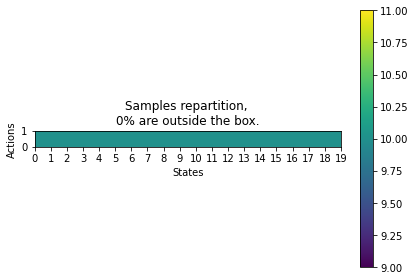

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, _ = count_samples(replay_buffer.states, replay_buffer.actions, states_boxes, actions_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Optimal Q function

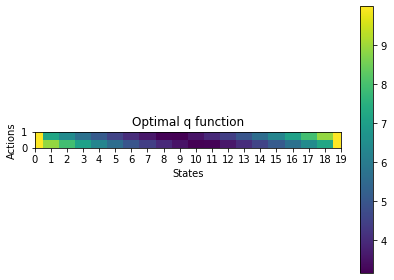

In [5]:
optimal_q = env.optimal_Q_mesh()
optimal_v = optimal_q.max(axis=1)

q_visu_mesh = TwoDimesionsMesh(states, actions, 0)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Train Q with Fitted-Q

In [6]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import TableQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = TableQ(
    1,
    n_states,
    1,
    n_actions,
    gamma,
    q_network_key,
    None,
    random_weights_key,
    learning_rate,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

training_losses_q = np.zeros(max_bellman_iterations)
validation_losses_q = np.zeros(max_bellman_iterations)
value_functions_q = np.zeros((max_bellman_iterations, n_states))

params_target = q.params
q_i = q.discretize(q.to_weights(params_target).reshape((-1, q.weights_dimension)), states, actions)[0]

for bellman_iteration in tqdm(range(max_bellman_iterations)):
    for step in range(fitting_steps_q):
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)

    q_i_plus_1 = q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_q[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_q[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    value_functions_q[bellman_iteration] = env.value_function(policy_q)

    params_target = q.params
    q_i = q_i_plus_1
    print(policy_q)

  0%|          | 0/2 [00:00<?, ?it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


## Optimal PBO

In [7]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_pbo import TabularPBO

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

pbo_optimal = TabularPBO(q, max_bellman_iterations, False, pbo_network_key, learning_rate, n_actions)
pbo_optimal.params["TabularPBONet/linear"]["w"] = gamma * env.transition_proba.T
pbo_optimal.params["TabularPBONet/linear"]["b"] = env.R.T

training_losses_optimal = np.zeros(max_bellman_iterations_validation)
validation_losses_optimal = np.zeros(max_bellman_iterations_validation)
value_functions_optimal = np.zeros((max_bellman_iterations_validation, n_states))


batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo_optimal(pbo_optimal.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_optimal[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_optimal[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    value_functions_optimal[bellman_iteration] = env.value_function(policy_q)
    print(policy_q)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]


## Collect weights

In [8]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_random = TableQ(
    1,
    n_states,
    1,
    n_actions,
    gamma,
    q_network_key,
    None,
    random_weights_key,
    learning_rate=None,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_random.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train non linear PBO

In [9]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import TabularPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo_non_linear = TabularPBO(q_random, max_bellman_iterations, add_infinity_non_linear, pbo_network_key, learning_rate, n_actions)
importance_iteration = jnp.ones(max_bellman_iterations + 1)
importance_iteration = importance_iteration.at[-1].set(0)

for _ in tqdm(range(training_steps)):
    params_target = pbo_non_linear.params

    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo_non_linear.params, pbo_non_linear.optimizer_state, _ = pbo_non_linear.learn_on_batch(
                    pbo_non_linear.params, params_target, pbo_non_linear.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

training_losses_non_linear = np.zeros(max_bellman_iterations_validation)
validation_losses_non_linear = np.zeros(max_bellman_iterations_validation)
value_functions_non_linear = np.zeros((max_bellman_iterations_validation, n_states))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo_non_linear(pbo_non_linear.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_non_linear[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_non_linear[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    value_functions_non_linear[bellman_iteration] = env.value_function(policy_q)
    print(policy_q)

  0%|          | 0/300 [00:00<?, ?it/s]

[1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0]
[1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0]
[1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0]
[0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


## Train linear PBO

In [10]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity_linear, pbo_network_key, learning_rate)
importance_iteration = jnp.ones(max_bellman_iterations + 1)


for _ in tqdm(range(training_steps)):
    params_target = pbo.params
    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

training_losses = np.zeros(max_bellman_iterations_validation)
validation_losses = np.zeros(max_bellman_iterations_validation)
value_functions = np.zeros((max_bellman_iterations_validation, n_states))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    value_functions[bellman_iteration] = env.value_function(policy_q)
    print(policy_q)

  0%|          | 0/300 [00:00<?, ?it/s]

[0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0]
[0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0]
[0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0]
[1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0]
[1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0]
[1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]


## Visualize errors in Q functions

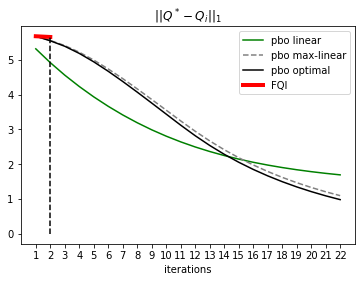

In [11]:
import matplotlib.pyplot as plt 

iterations = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations, validation_losses, label="pbo linear", color="green")
plt.plot(iterations, validation_losses_non_linear, label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, validation_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), validation_losses_q, label="FQI", color="red", linewidth=4)
plt.vlines(max_bellman_iterations, 0, np.max(validation_losses_q), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| Q^* - Q_i ||_1$")
_ = plt.legend()

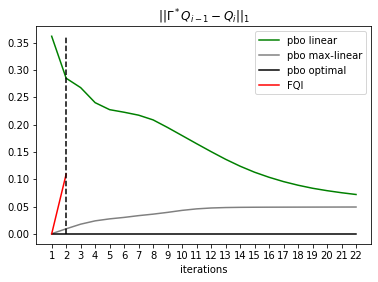

In [12]:
plt.plot(iterations, training_losses, label="pbo linear", color="green")
plt.plot(iterations, training_losses_non_linear, label="pbo max-linear", color="grey")
plt.plot(iterations, training_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), training_losses_q, label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, np.maximum(np.max(training_losses_q), np.max(training_losses)), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_1$")
_ = plt.legend()

## Understanding the learning process

In [13]:
empirical_transition_proba = np.zeros((n_states, n_states * n_actions))
empirical_reward = np.zeros(n_states * n_actions)

for idx_sample in range(len(replay_buffer.states)):
    state = replay_buffer.states[idx_sample, 0]
    action = replay_buffer.actions[idx_sample, 0]
    reward = replay_buffer.rewards[idx_sample, 0]
    next_state = replay_buffer.next_states[idx_sample, 0]

    empirical_transition_proba[next_state, state * n_actions + action] += 1 
    empirical_reward[state * n_actions + action] += reward

empirical_transition_proba /= n_repetitions
empirical_reward /= n_repetitions

print(f"Probability transition:")
print("Empirical vs Theoretical - ", np.linalg.norm(empirical_transition_proba - env.transition_proba.T))
print("Empirical vs Learnt - ", np.linalg.norm(empirical_transition_proba - pbo_non_linear.params["TabularPBONet/linear"]["w"] / gamma))
print("Theoretical vs Learnt - ", np.linalg.norm(env.transition_proba.T - pbo_non_linear.params["TabularPBONet/linear"]["w"] / gamma))
print("\nReward:")
print("Empirical vs Theoretical - ", np.linalg.norm(empirical_reward - env.R.T))
print("Empirical vs Learnt - ", np.linalg.norm(empirical_reward - pbo_non_linear.params["TabularPBONet/linear"]["b"]))
print("Theoretical vs Learnt - ", np.linalg.norm(env.R.T - pbo_non_linear.params["TabularPBONet/linear"]["b"]))


Probability transition:
Empirical vs Theoretical -  0.86023253
Empirical vs Learnt -  0.0046603624
Theoretical vs Learnt -  0.8601396

Reward:
Empirical vs Theoretical -  0.0
Empirical vs Learnt -  0.0035159388
Theoretical vs Learnt -  0.0035159388


## Visualize errors in preformances

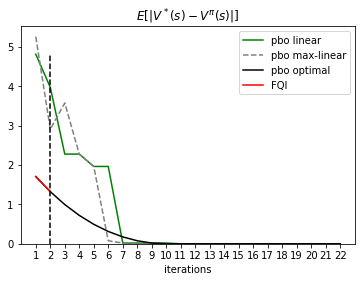

In [14]:
plt.plot(iterations, np.abs(value_functions - optimal_v).mean(axis=1), label="pbo linear", color="green")
plt.plot(iterations, np.abs(value_functions_non_linear - optimal_v).mean(axis=1), label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, np.abs(value_functions_optimal - optimal_v).mean(axis=1), label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), np.abs(value_functions_q - optimal_v).mean(axis=1), label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, np.abs(value_functions - optimal_v).mean(axis=1).max(), color="black", linestyle="--")

plt.xticks(iterations)
plt.ylim(0)
plt.xlabel("iterations")

plt.title(r"$E[| V^*(s) - V^{\pi}(s) |]$")
_ = plt.legend()